## Imports

In [1]:
import os
from time import time
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

## Data load funtcions

In [2]:
def load_mnist_images(filename: str, path: str = 'mnist') -> NDArray:
    with open(os.path.join(path, filename), 'rb') as file:
        _ = file.read(4)
        image_num = int.from_bytes(file.read(4))
        image_h = int.from_bytes(file.read(4))
        image_w = int.from_bytes(file.read(4))
        images = np.fromfile(file, dtype=np.uint8).reshape((image_num, image_h, image_w))
    return images

def load_mnist_labels(filename: str, path: str = 'mnist') -> NDArray:
    with open(os.path.join(path, filename), 'rb') as file:
        _ = file.read(4)
        label_num = int.from_bytes(file.read(4))
        labels = np.fromfile(file, dtype=np.uint8).reshape((label_num))
    return labels

## Data loading and checking

In [3]:
train_images = load_mnist_images('train-images.idx3-ubyte')
train_labels = load_mnist_labels('train-labels.idx1-ubyte')
print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [4]:
test_images = load_mnist_images('t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('t10k-labels.idx1-ubyte')
print(test_images.shape, test_labels.shape)

(10000, 28, 28) (10000,)


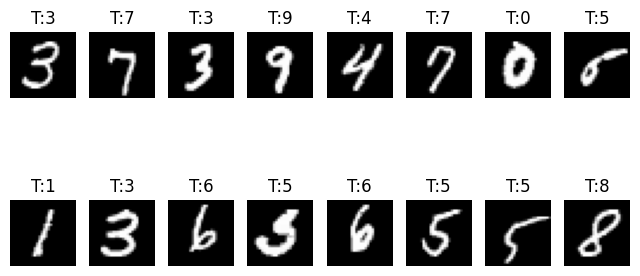

In [5]:
random_sample_size = 2 * 8
random_ids = np.random.choice(train_labels.shape[0], random_sample_size)
plt.figure(figsize=(random_sample_size // 2, 4))
for i in range(random_sample_size):
    plt.subplot(2, random_sample_size // 2, i + 1)
    plt.axis(False)
    plt.title(f'T:{train_labels[random_ids[i]]}')
    plt.imshow(train_images[random_ids[i]], cmap='grey')
plt.show()

## Neural network class

In [6]:
class FullyConnectedNN:
    def __init__(self, hidden_layer_size: int = 300, learning_rate: float = 0.1, max_iter: int = 20, batch_size: int = 32) -> None:
        # parameters of NN
        self.input_size = 28 * 28                   # N
        self.output_size = 10                       # M
        self.hidden_layer_size = hidden_layer_size  # K
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size  # B

        # weights initialization - Xavier/Glorot uniform
        # shape (N, K)
        self.__weights1 = np.random.uniform(
        -np.sqrt(6 / (self.input_size + self.hidden_layer_size)),
        np.sqrt(6 / (self.input_size + self.hidden_layer_size)),
        (self.input_size, self.hidden_layer_size))
        # shape (K, M)
        self.__weights2 = np.random.uniform(
        -np.sqrt(6 / (self.hidden_layer_size + self.output_size)),
        np.sqrt(6 / (self.hidden_layer_size + self.output_size)),
        (self.hidden_layer_size, self.output_size))
        # biases initialization - zeros
        # shape (1, K)
        self.__bias1 = np.zeros((1, self.hidden_layer_size))
        # shape (1, M)
        self.__bias2 = np.zeros((1, self.output_size))

    def predict(self, X: NDArray) -> NDArray:
        # predict is argmax for softmax output
        return np.argmax(self.__forward(X), axis=1)
    
    def score(self, X: NDArray, y: NDArray) -> float:
        # accuracy score for predicted classes
        return float(np.mean(y == self.predict(X)))
    
    def __ReLU(self, x: NDArray) -> NDArray:
        return np.maximum(0, x)
    
    def __dReLU(self, x: NDArray) -> NDArray:
        return np.where(x > 0, 1, 0)
    
    def __softmax(self, x: NDArray) -> NDArray:
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    
    def __cross_entropy(self, X: NDArray, y: NDArray) -> float:
        y_forw = self.__forward(X)
        np.subtract.at(y_forw, (np.arange(y_forw.shape[0]), y), 1)
        np.negative.at(y_forw, (np.arange(y_forw.shape[0]), y))
        return float(-np.mean(np.sum(np.log(1 - y_forw), axis=1)))

    def __forward(self, X: NDArray) -> NDArray:
        self.__out1 = (X @ self.__weights1) + self.__bias1            # sum1
        self.__out2 = self.__ReLU(self.__out1)                        # phi1
        self.__out3 = (self.__out2 @ self.__weights2) + self.__bias2  # sum2
        self.__out4 = self.__softmax(self.__out3)                     # phi2
        return self.__out4
    
    def __backward(self, X: NDArray, y: NDArray, y_forw: NDArray) -> None:
        # grad of loss by sum2; shape (B, M)
        grad2 = y_forw.copy()
        np.subtract.at(grad2, (np.arange(grad2.shape[0]), y), 1)
        grad2 /= self.batch_size
        # grad of loss by sum1; shape (B, K)
        grad1 = (grad2 @ self.__weights2.T) * self.__dReLU(self.__out1)
        # weight change
        self.__weights1 -= self.learning_rate * (X.T @ grad1)
        self.__weights2 -= self.learning_rate * (self.__out2.T @ grad2)
        self.__bias1 -= self.learning_rate * np.sum(grad1, axis=0, keepdims=True)
        self.__bias2 -= self.learning_rate * np.sum(grad2, axis=0, keepdims=True)
    
    def train(self, X_train: NDArray, y_train: NDArray, X_test: NDArray, y_test: NDArray) -> None:
        # total time
        total_time = 0.0
        # train loop
        for iter in range(self.max_iter):
            # iter start time
            start_time = time()
            # shuffle data
            indices_perm = np.random.permutation(y_train.shape[0])
            X_perm = X_train[indices_perm]
            y_perm = y_train[indices_perm]
            # go through batches
            for i in range(0, y_train.shape[0], self.batch_size):
                X_batch = X_perm[i : i + self.batch_size]
                y_batch = y_perm[i : i + self.batch_size]
                # forward step
                y_forw = self.__forward(X_batch)
                # backward step
                self.__backward(X_batch, y_batch, y_forw)
            # iter time
            iter_time = time() - start_time
            total_time += iter_time
            print(f'[Iter {iter + 1 :02d}/{self.max_iter}]: loss = {self.__cross_entropy(X_train, y_train) :.6f}, acc = {self.score(X_train, y_train) :.6f}, time = {iter_time :.6f} s')
        print(f'Total train time: {total_time :.6f} s')
        print(f'Result on test: loss = {self.__cross_entropy(X_test, y_test) :.6f}, acc = {self.score(X_test, y_test) :.6f}')

## Data preparation

In [7]:
# [0, 1] normalization
train_images = train_images / 255.0
test_images = test_images / 255.0

In [8]:
# flatten
train_images = train_images.reshape((-1, 28 * 28))
test_images = test_images.reshape((-1, 28 * 28))
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


## Train

In [9]:
%%time
nn = FullyConnectedNN()
nn.train(train_images, train_labels, test_images, test_labels)

[Iter 01/20]: loss = 0.261701, acc = 0.958617, time = 4.273094 s
[Iter 02/20]: loss = 0.186891, acc = 0.970717, time = 4.166748 s
[Iter 03/20]: loss = 0.126968, acc = 0.980183, time = 4.076549 s
[Iter 04/20]: loss = 0.104592, acc = 0.984817, time = 3.998076 s
[Iter 05/20]: loss = 0.084809, acc = 0.987467, time = 3.922740 s
[Iter 06/20]: loss = 0.073308, acc = 0.989600, time = 3.904118 s
[Iter 07/20]: loss = 0.054073, acc = 0.992767, time = 3.953848 s
[Iter 08/20]: loss = 0.052281, acc = 0.993600, time = 3.933243 s
[Iter 09/20]: loss = 0.039429, acc = 0.995917, time = 4.004827 s
[Iter 10/20]: loss = 0.032315, acc = 0.997400, time = 3.851343 s
[Iter 11/20]: loss = 0.030497, acc = 0.997250, time = 4.069369 s
[Iter 12/20]: loss = 0.027728, acc = 0.997783, time = 4.228906 s
[Iter 13/20]: loss = 0.022950, acc = 0.998483, time = 4.144580 s
[Iter 14/20]: loss = 0.019549, acc = 0.998900, time = 4.154627 s
[Iter 15/20]: loss = 0.016092, acc = 0.999333, time = 4.039423 s
[Iter 16/20]: loss = 0.01

## Result

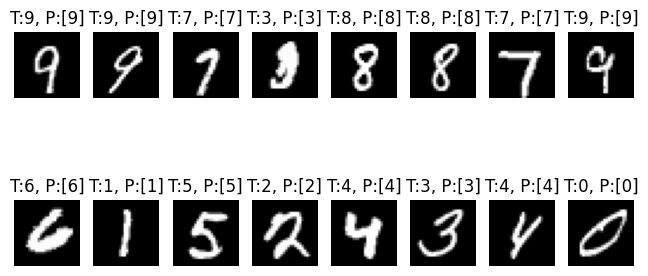

In [10]:
random_sample_size = 2 * 8
random_ids = np.random.choice(train_labels.shape[0], random_sample_size)
plt.figure(figsize=(random_sample_size // 2, 4))
for i in range(random_sample_size):
    plt.subplot(2, random_sample_size // 2, i + 1)
    plt.axis(False)
    plt.title(f'T:{train_labels[random_ids[i]]}, P:{nn.predict(train_images[random_ids[i]].reshape((1, 28 * 28)))}')
    plt.imshow(train_images[random_ids[i]].reshape((28, 28)), cmap='grey')
plt.show()